In [1]:
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
spi_cat = fits.open('spi_cat.fits.gz')

In [3]:
spi_cat.info()

Filename: spi_cat.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SPICAT        1 BinTableHDU     30   256R x 7C   [20A, E, E, 16E, 16E, 4A, 4E]   
  2  EBOUNDS       1 BinTableHDU     22   16R x 4C   [E, E, E, E]   


In [4]:
ecen = spi_cat[2].data['E_CEN'] * u.keV
eerr = spi_cat[2].data['E_ERR'] * u.keV
emin = spi_cat[2].data['E_MIN'] * u.keV
emax = spi_cat[2].data['E_MAX'] * u.keV

In [5]:
spi_cat[1].columns

ColDefs(
    name = 'NAME'; format = '20A'
    name = 'GLON'; format = 'E'; unit = 'deg'
    name = 'GLAT'; format = 'E'; unit = 'deg'
    name = 'FLUX'; format = '16E'; unit = 'ph/cm2/s/keV'
    name = 'FLUX_ERR'; format = '16E'; unit = 'ph/cm2/s/keV'
    name = 'FITFUN'; format = '4A'
    name = 'FITPARS'; format = '4E'
)

In [6]:
spi_cat[1].data['NAME']

chararray(['SAX J1747.0-2853', 'IGR J17507-2856', 'Oph Cluster',
           'SLX 1735-269', 'RX J1832-330', 'AX J1749.1-2733', 'GX 1+4',
           'XTE J1807-294', 'GX 3+1', '4U 1820-303', 'IGR J17544-2619',
           'GRS 1758-258', 'V1223 Sgrgg', 'GX 5-1', 'IGR J17348-2045',
           'IGR J17461-2204', 'IGR J18173-2509', 'IGR J17597-2201',
           '4U 1745-203', 'GX 9+9', 'GS 1826-24', 'SAX J1802.7-201ee',
           'SGR 1806-20', 'PSR J1811-1926', 'HETE J1900.1-2455',
           'PKS 1830-211', 'IGR J18135-1751ee', 'GX 13+1',
           '2E 1739.1-1210', 'SAX J1818.6-1703', 'IGR J18027-1455',
           'NGC 7172', 'GX 17+2', 'AX J1820.5-1434', 'RX J1826.2-1450',
           'IGR J18214-1318', 'IGR J17303-0601', 'M 1812-12',
           'IGR J183047-1232', 'IGR J18256-1035', 'SNR 021.5-00.9',
           'AX J183039-1002', 'IGR J18259-0706', 'IGR J18325-0756',
           'SWIFT J1753.5-0127', 'AX J1838.0-0655ff', '4U 1850-087',
           'AX J1841.0-0535', 'IGR J18450-0435', '

In [21]:
np.unique(spi_cat[1].data['FITFUN'])

chararray(['BPLW', 'PLCO', 'PWLW'], dtype='<U4')

In [147]:
def PWLW(x,pars):
    return pars[0]*x**pars[1]

def PLCO(x,pars):
    return pars[0]*(x)**pars[1]*np.exp(-x/pars[2])

def BPLW(x,pars):
    val = np.zeros(len(x))
    lo_idx = np.where(x <= pars[2])[0]
    hi_idx = np.where(x > pars[2])[0]
    val[lo_idx] = pars[0]*x[lo_idx]**pars[1]
    val[hi_idx] = pars[0]*pars[2]**(pars[1]-pars[3])*x[hi_idx]**pars[3]
    return val

In [168]:
src_idx = np.where(spi_cat[1].data['NAME'] == 'Circinus galaxy')[0][0]
src_idx

167

In [169]:
spi_cat[1].data['FITFUN'][src_idx]

'PLCO'

In [170]:
spi_cat[1].data['FITPARS'][src_idx]

array([ 2.558096e-03, -5.000000e-01,  2.290000e+01,  0.000000e+00],
      dtype=float32)

In [171]:
if spi_cat[1].data['FITFUN'][src_idx] == 'PWLW':
    func = PWLW
elif spi_cat[1].data['FITFUN'][src_idx] == 'PLCO':
    func = PLCO
else:
    func = BPLW

In [172]:
func

<function __main__.PLCO(x, pars)>

In [173]:
fitpars = spi_cat[1].data['FITPARS'][src_idx]

In [174]:
spec_model = func(ecen.value,fitpars) / u.cm**2 / u.s / u.keV
ee_spec_model = (spec_model * ecen**2).to(u.erg/u.cm**2/u.s)

In [175]:
spec = spi_cat[1].data['FLUX'][src_idx] / u.cm**2 / u.s / u.keV
spec_err = spi_cat[1].data['FLUX_ERR'][src_idx] / u.cm**2 / u.s / u.keV

In [176]:
threshold_snr = 1

good_idx = np.where((spec/spec_err).value > threshold_snr)[0]
bad_idx = np.where(((spec/spec_err).value <= threshold_snr) & (np.isnan((spec/spec_err).value) == False))[0]

/Users/thomassiegert/.virtualenvs/3ml_stuff/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


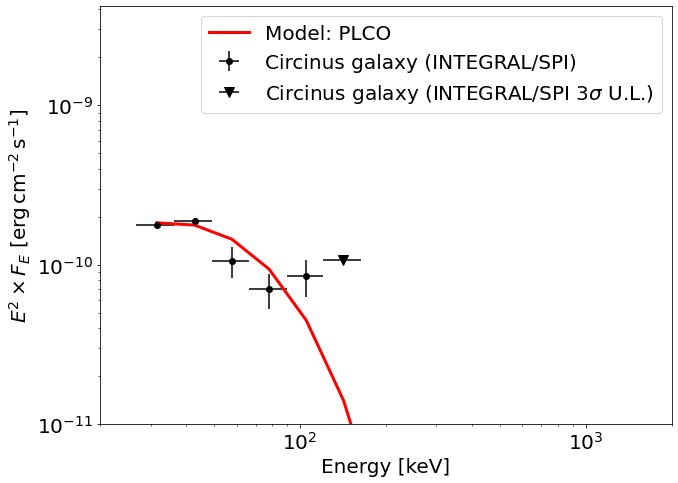

In [178]:
plt.figure(figsize=(10.24,7.68))
plt.errorbar(ecen.value[good_idx],
             ((spec*ecen**2).to(u.erg/u.cm**2/u.s)).value[good_idx],
             xerr=eerr.value[good_idx],
             yerr=((spec_err*ecen**2).to(u.erg/u.cm**2/u.s)).value[good_idx],
             marker='o',linestyle='',color='black',
             label='{0} (INTEGRAL/SPI)'.format(spi_cat[1].data['NAME'][src_idx]))


ul = 3

plt.errorbar(ecen.value[bad_idx],
             ((spec_err*ecen**2).to(u.erg/u.cm**2/u.s)).value[bad_idx]*ul,
             xerr=eerr.value[bad_idx],
             marker='v',linestyle='',color='black',markersize=10,
             label=r'{0} (INTEGRAL/SPI ${1}\sigma$ U.L.)'.format(spi_cat[1].data['NAME'][src_idx],ul))

plt.plot(ecen.value,ee_spec_model.value,color='red',linewidth=3,
         label='Model: {0}'.format(spi_cat[1].data['FITFUN'][src_idx]))


plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-11)
plt.xlim(20,2000)
plt.legend(fontsize=20)
plt.xlabel('Energy [keV]',fontsize=20)
plt.ylabel(r'$E^2 \times F_E$ [$\mathrm{erg\,cm^{-2}\,s^{-1}}$]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);